In [37]:
%load_ext autoreload
%autoreload 2

import os.path
import pandas as pd
import numpy as np
import time
from datetime import timedelta
import tensorflow as tf
import json
from loadData import loadData, convertToBatches
from RNN import RNN, ExitCriteria, Parameters, Directories, RNNCellType

import logging
logging.basicConfig(filename='train.log', level=logging.DEBUG)
logger = logging.getLogger(__name__)

inputDir = "GEFCom2012/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
modelDirectory = "GEFCom2012/Model"
summaryDirectory = "GEFCom2012/Model"
maxGradient = 1
timeSteps = 24
nHorizons = 24
batchSize = 1
nHiddenUnits = 200
nLayers = 2
init = 0.05
inputSize = 1
keepProbability = 1
maxEpochs=200
learningRate=1.0
maxIterations = 1000000
loggingInterval = 100
cellType = RNNCellType.ESN
#Load Data
trainingDfs, completeDfs = loadData("GEFCom2012/", maxDataPoints = -1)
ts = trainingDfs[0][["zone.1"]].values
batches = convertToBatches(ts, timeSteps, batchSize, nHorizons)


ts = trainingDfs[0][["zone.1"]].values
tsTest = completeDfs[0][["zone.1"]].values
tsTest = tsTest[len(ts):]
ts = ts[-2160:] #only get 3 months of data
##Normalize ts
tsMean = ts.mean()
tsRange = ts.max()-ts.min()
ts = (ts-tsMean)/tsRange
tsTest = (tsTest-tsMean)/tsRange
if modelDirectory is None:
    logger.warn("Not saving a model.")
logger.info("Start Experiment")


In [ ]:
# Run training.
start_time = time.time()
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        model = RNN(maxGradient = maxGradient, 
                    timeSteps = timeSteps, 
                    nHorizons = nHorizons, 
                    inputSize = inputSize, 
                    nHiddenUnits = nHiddenUnits, 
                    cellType = cellType,
                    nLayers = nLayers)
        with tf.Session() as session:
            tsTarget, tsFit, lastState = model.train(session = session, 
                        init = init, 
                        ts = ts, 
                        parameters = Parameters(learningRate, keepProbability, batchSize), 
                        exitCriteria = ExitCriteria(maxIterations, maxEpochs), 
                        validation = None, 
                        loggingInterval = loggingInterval, 
                        directories = Directories(modelDirectory, summaryDirectory),
                        logger = logger)
logger.info("Total training time %s" % timedelta(seconds=(time.time() - start_time)))

In [14]:
# Test
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        with tf.Session() as session:
            model = RNN.restore(session, modelDirectory)
            tsTarget, tsPredicted, epoch_cost = model.predict(session = session,
                                                              startState = lastState, 
                                                              tsTest = tsTest,
                                                              batchSize = 1)

0.904882392198


4.0767728836322963

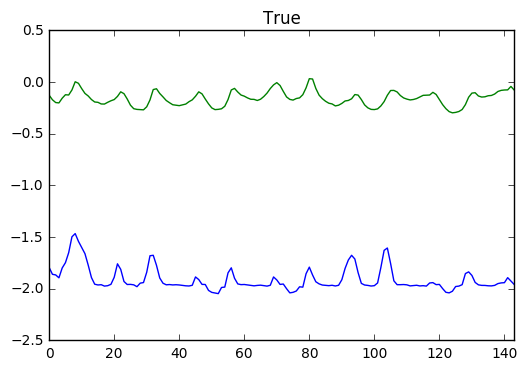

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline  
print np.sqrt(np.mean(np.square(tsTarget[:, 0]-tsPredicted[:, 0])))
x = pd.Series(tsPredicted[:, 23])
y = pd.Series(tsTarget[:, 23])
x.plot(title="Fited")
#plt.figure()
y.plot(title="True")

x = x*tsRange+tsMean
y = y*tsRange+tsMean
np.mean(np.abs(x-y)/y)

In [ ]:
from fbprophet import Prophet
trainingDfs, completeDfs = loadData("GEFCom2012/", maxDataPoints = -1)
df = trainingDfs[0][["DateTime", "zone.1"]]
df = df.rename(columns={"zone.1":"y", "DateTime":"ds"})
tsTest = completeDfs[0][["zone.1"]].values
tsTest = tsTest[len(df):]
m = Prophet()
m.fit(df);

In [ ]:
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)

In [ ]:
m.plot(forecast)
plt.figure()
x = pd.Series(forecast.tail(168)[["yhat"]].values[:,0])
y = pd.Series(tsTest.flatten())
x.plot()
y.plot()

In [ ]:
a = forecast.tail(168)[["yhat"]].values

In [ ]:
tsTest = completeDfs[0][["zone.1"]].values
tsTest = tsTest[len(df):]
